# Robustness to atlas variation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

import milopy
import milopy.core as milo

In [3]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [4]:
%load_ext rpy2.ipython

In [5]:
%%R
library(tidyverse)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [6]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');

In [7]:
figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/atlas_subsampling/'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [8]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [9]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6], 'closest_ACR':pal[2], 'random_ACR':pal[8]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [10]:
%%R -i figdir -i design_palette_df
design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

In [11]:

short_pop_names = {
    "DC":'conventional_dendritic_cell', 
    "naive B":'naive_B_cell',
    "memory B":'memory_B_cell',
    "CM CD4+T":'central_memory_CD4_positive_alpha_beta_T_cell', 
    'plasmablast':'plasmablast',
    'platelet':'platelet', 
 "pDC":'plasmacytoid_dendritic_cell',
     "neutrophil":'neutrophil',
#     "cDC":'conventional_dendritic_cell',
 'naive CD4+T':'naive_thymus_derived_CD4_positive_alpha_beta_T_cell',
"classical monocyte":'classical_monocyte', 
 'erythrocyte':'erythrocyte',
       "naive CD8+T":'naive_thymus_derived_CD8_positive_alpha_beta_T_cell',
       "NK":'natural_killer_cell',
       "EM CD8+T":'effector_memory_CD8_positive_alpha_beta_T_cell',
       'MAIT':'mucosal_invariant_T_cell', 
 'CD14lo CD16hi monocyte':'CD14_low_CD16_positive_monocyte'}

short_pop_names={v:k for k,v in short_pop_names.items()}

Get size of OOR populations

In [434]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
population_obs = 'cell_type'
batch_obs = 'dataset_id'

## Get OOR state population size
oor_state_size = {}
for d in [d for d in os.listdir(outdir) if d.endswith('_seed2022') and d.startswith('qPBMC_500cells_demo_perturb')]:
        if 'neutrophil' not in d:
            acr_adata = sc.read_h5ad(outdir + d +'/acr_design.h5ad', backed=True)
            ct = acr_adata.obs[acr_adata.obs['OOR_state']==1]['cell_type'].unique()[0]
            oor_state_size[ct] = acr_adata.obs['OOR_state'].sum()

oor_state_frac = {k:v/(500*(14+16)) for k,v in oor_state_size.items()}
oor_state_frac

oor_state_size

{'memory_B_cell': 398,
 'conventional_dendritic_cell': 108,
 'naive_B_cell': 601,
 'central_memory_CD4_positive_alpha_beta_T_cell': 1811,
 'plasmablast': 15,
 'platelet': 123,
 'plasmacytoid_dendritic_cell': 43,
 'naive_thymus_derived_CD4_positive_alpha_beta_T_cell': 779,
 'classical_monocyte': 391,
 'erythrocyte': 10,
 'naive_thymus_derived_CD8_positive_alpha_beta_T_cell': 396,
 'natural_killer_cell': 1067,
 'effector_memory_CD8_positive_alpha_beta_T_cell': 1436,
 'mucosal_invariant_T_cell': 203,
 'CD14_low_CD16_positive_monocyte': 124}

## Prepare dataset stats 

In [12]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/'
population_obs = 'cell_type'
batch_obs = 'dataset_id'
query_batch = '10_1038_s41591_021_01329_2'

In [113]:
adata = sc.read_h5ad(outdir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad', backed=True)

Save dataset IDs

In [24]:
dataset_id_ls = adata.obs[batch_obs].unique().tolist()
dataset_id_ls.remove(query_batch)

with open(outdir + 'atlas_dataset_IDs.txt', 'w') as f:
    f.writelines('\n'.join(dataset_id_ls))

Save celltype counts

In [566]:
## Count number of cells per celltype and dataset
ct_size = adata.obs.groupby(['dataset_id', 'cell_type']).size().reset_index()
ct_size.columns = ['dataset_id', 'cell_type', 'n_cells']
ct_size = ct_size[ct_size.n_cells > 0]

## Count number of cells per celltype and dataset
donor_size = adata.obs.drop_duplicates(['dataset_id', 'donor_id']).groupby('dataset_id').size().reset_index()
donor_size.columns = ['dataset_id', 'n_donors']
# ct_size = ct_size[ct_size.n_cells > 0]
ct_size = pd.merge(ct_size, donor_size)

In [567]:
ct_size.to_csv(outdir + 'atlas_datasets_ncells_ct.csv')

## Atlas size

see `run_suboptimal_atlas.py`

In [614]:
outdir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_CZI_integration_filtered/suboptimal_atlas_analysis/'

In [616]:
simdirs = [x for x in os.listdir(outdir) if x.startswith('suboptimal')]
keep_cols = ['Recall', 'Precision', 'AUPRC', 'no_skill_thresh', 'design', 'OOR_state_name', 'atlas_size']
auprc_df_all = pd.DataFrame()
for s in simdirs:
    try:
        auprc_df = pd.read_csv(outdir + s +'/auprc_df.csv', index_col=0)
        auprc_df_all = pd.concat([auprc_df_all, auprc_df])
    except FileNotFoundError:
        continue

auprc_df_all['OOR_state_name'] = auprc_df_all['OOR_state_name'].str.split("_withOOR", expand=True)[0]
auprc_df_all['OOR_state_name_pl'] = [short_pop_names[x] for x in auprc_df_all['OOR_state_name']]

auprc_df_min = auprc_df_all.drop_duplicates(['AUPRC', 'no_skill_thresh', 'design', 'OOR_state_name', 'atlas_size'])

In [619]:
simdirs = [x for x in os.listdir(outdir) if x.startswith('suboptimal')]
tpr_df_all = pd.DataFrame()
for s in simdirs:
    try:
        tpr_df = pd.read_csv(outdir + s +'/tpr_res_df.csv', index_col=0)
        tpr_df_all = pd.concat([tpr_df_all, tpr_df])
    except FileNotFoundError:
        continue

tpr_df_all['OOR_state_name'] = tpr_df_all['OOR_state_name'].str.split("_withOOR", expand=True)[0]

tpr_df_all['OOR_state_name_pl'] = [short_pop_names[x] for x in tpr_df_all['OOR_state_name']]

In [623]:
auprc_df_min = pd.merge(auprc_df_min, tpr_df_all[['TPR', 'FPR', 'design', "OOR_state_name", 'n_studies', 'atlas_size','OOR_state_name_pl']])

In [624]:
%%R -i auprc_df_min
head(auprc_df_min)

  Recall    Precision     AUPRC no_skill_thresh design      OOR_state_name
0      1 0.1077283372 0.8934424    0.1077283372    ACR natural_killer_cell
1      1 0.0127900603 0.6697585    0.0127900603     AR natural_killer_cell
2      1 0.0267379679 0.8692393    0.0267379679    ACR  classical_monocyte
3      1 0.0007749435 0.9629173    0.0007749435     AR  classical_monocyte
4      1 0.0101522843 0.6646786    0.0101522843    ACR            platelet
5      1 0.0007455533 0.1129371    0.0007455533     AR            platelet
  n_studies atlas_size                       CT_oi  OOR_state_name_pl       TPR
0        10      65312 natural_killer_cell_withOOR                 NK 0.6086957
1        10      65312 natural_killer_cell_withOOR                 NK 1.0000000
2        12     546567  classical_monocyte_withOOR classical monocyte 0.7600000
3        12     546567  classical_monocyte_withOOR classical monocyte 1.0000000
4        11     114299            platelet_withOOR           platelet 0.000

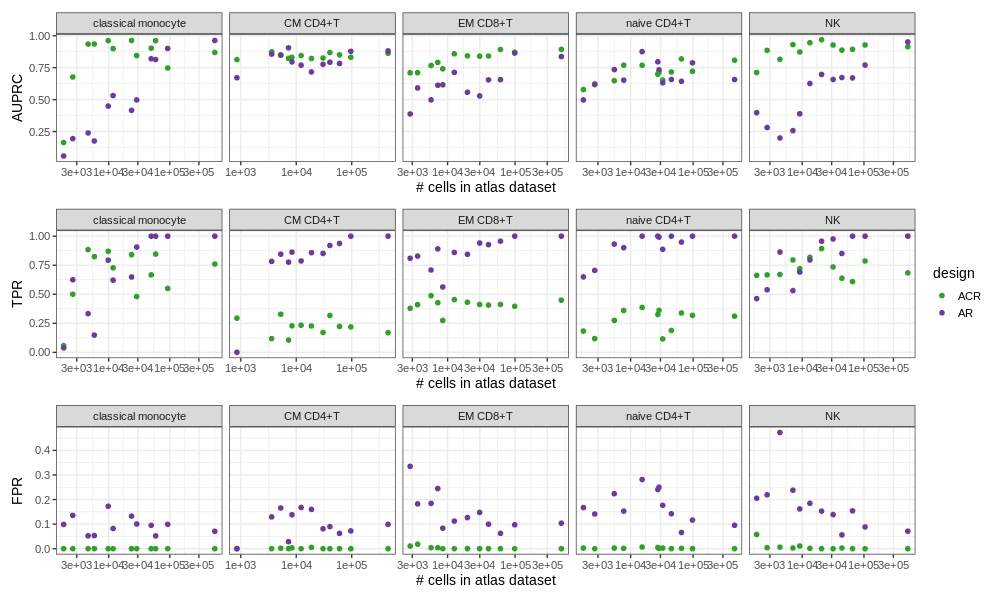

In [636]:
%%R -w 1000 -h 600
cts_oi <- c('CM CD4+T', 'EM CD8+T', 'NK', 'naive CD4+T', 'classical monocyte')

pl_ls <- lapply(c('AUPRC', 'TPR', 'FPR'), function(m) {auprc_df_min %>%
    filter(OOR_state_name_pl %in% cts_oi) %>%
    rename(metric = m) %>%
    ggplot(aes(atlas_size, metric, color=design)) +
    geom_point(size=2) +
    scale_x_log10() +
    facet_wrap(OOR_state_name_pl~., scales='free_x', nrow=1) +
    scale_color_manual(values=design_palette) +
#     ggpubr::stat_cor() +
    ylab(m) +
    xlab('# cells in atlas dataset') +
    theme_bw(base_size=14) })
    # ggsave(paste0(figdir, 'atlas_size_ncells'))
    
wrap_plots(pl_ls) + 
plot_layout(ncol=1, guides='collect') +
ggsave(paste0(figdir, 'atlas_size_metrics_facets.pdf'), width=16, height=11) +
ggsave(paste0(figdir, 'atlas_size_metrics_facets.png'), width=16, height=11)

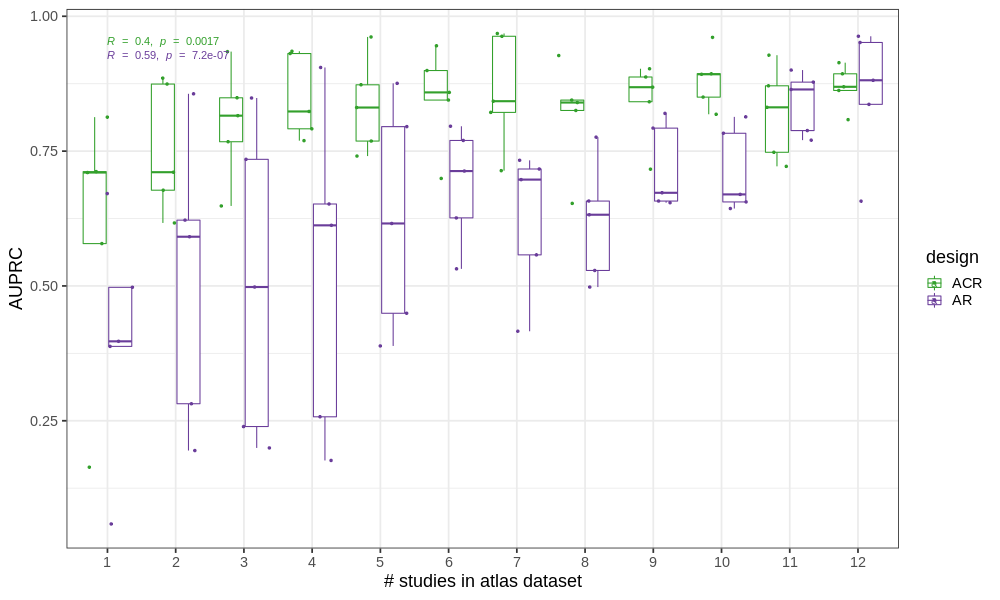

In [552]:
%%R -w 1000 -h 600
cts_oi <- c('CM CD4+T', 'EM CD8+T', 'NK', 'naive CD4+T', 'classical monocyte'
           )

auprc_df_min %>%
filter(OOR_state_name_pl %in% cts_oi) %>%
ggplot(aes(as.factor(n_studies), AUPRC, color=design)) +
geom_boxplot(outlier.alpha=0) +
geom_point(size=1, position=position_jitterdodge()) +
# facet_wrap(OOR_state_name_pl~., scales='free_x') +
scale_color_manual(values=design_palette) +
ggpubr::stat_cor(aes(x=n_studies)) +
xlab('# studies in atlas dataset') +
theme_bw(base_size=18) +
ggsave(paste0(figdir, 'AUPRC_atlas_size.pdf'), width=10, height=6)

## Leave-one-out robustness

See `run_atlas_leaveoneout.py`

In [630]:
outdir = '/lustre/scratch126/cellgen/team205/ed6/PBMC_CZI_integration_filtered/suboptimal_atlas_analysis/'

In [631]:
ct_size = pd.read_csv(outdir + 'atlas_datasets_ncells_ct.csv', index_col=0)

In [632]:
simdirs = [x for x in os.listdir(outdir) if x.startswith('leaveoneout')]
keep_cols = ['Recall', 'Precision', 'AUPRC', 'no_skill_thresh', 'design', 'OOR_state_name', 'remove_dataset']
auprc_df_all = pd.DataFrame()
for s in simdirs:
    try:
        auprc_df = pd.read_csv(outdir + s +'/auprc_df.csv', index_col=0)
        auprc_df_all = pd.concat([auprc_df_all, auprc_df[keep_cols]])
    except:
        continue

# read results without missing dataset
OOR_states = auprc_df_all.OOR_state_name.unique()

for ct in OOR_states:
    simdir = f'/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/tmp/qPBMC_500cells_demo_perturb_cell_type{ct}_queryBatchdataset_id10_1038_s41591_021_01329_2_seed2022/'
    auprc_full = pd.read_csv(simdir + 'AUPRC_res.milo.csv', index_col=0)
    auprc_full = auprc_full[auprc_full['design'] == 'ACR'].copy()
    auprc_full['remove_dataset'] = 'none'
    auprc_df_all = pd.concat([auprc_df_all, auprc_full[keep_cols]])

In [633]:
auprc_df_all['OOR_state_name_pl'] = [short_pop_names[x] for x in auprc_df_all['OOR_state_name']]

In [634]:
## Same excluded from main figures
exclude_cts = ['CD14_low_CD16_positive_monocyte', 'conventional_dendritic_cell',
       'erythrocyte', 'mucosal_invariant_T_cell', 'plasmablast',
       'plasmacytoid_dendritic_cell', 'platelet']

In [635]:
auprc_df_all = auprc_df_all[~auprc_df_all.OOR_state_name.isin(exclude_cts)]

In [636]:
%%R -i auprc_df_all
head(auprc_df_all)

  Recall Precision     AUPRC no_skill_thresh design
1      1 0.2584270 0.9016692        0.258427    ACR
2      1 0.2587177 0.9016692        0.258427    ACR
3      1 0.2590090 0.9016692        0.258427    ACR
4      1 0.2593010 0.9016692        0.258427    ACR
5      1 0.2595937 0.9016692        0.258427    ACR
6      1 0.2598870 0.9016692        0.258427    ACR
                                  OOR_state_name  remove_dataset
1 effector_memory_CD8_positive_alpha_beta_T_cell ye_lupus_normal
2 effector_memory_CD8_positive_alpha_beta_T_cell ye_lupus_normal
3 effector_memory_CD8_positive_alpha_beta_T_cell ye_lupus_normal
4 effector_memory_CD8_positive_alpha_beta_T_cell ye_lupus_normal
5 effector_memory_CD8_positive_alpha_beta_T_cell ye_lupus_normal
6 effector_memory_CD8_positive_alpha_beta_T_cell ye_lupus_normal
  OOR_state_name_pl
1          EM CD8+T
2          EM CD8+T
3          EM CD8+T
4          EM CD8+T
5          EM CD8+T
6          EM CD8+T


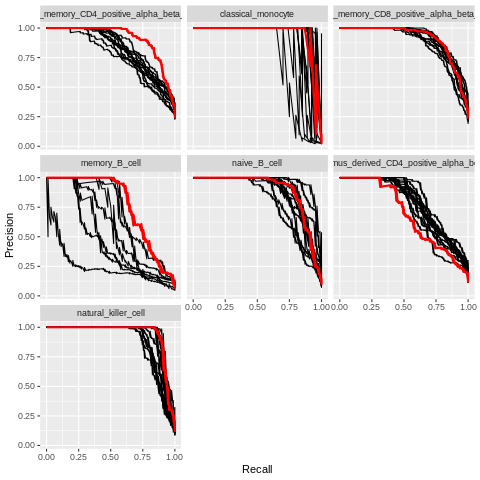

In [615]:
%%R
auprc_df_all %>%
ggplot(aes(Recall, Precision,group=remove_dataset)) +
geom_line() +
geom_line(data=. %>% filter(remove_dataset == 'none'), color='red', size=1) +
facet_wrap(OOR_state_name~.)

In [637]:
def get_atlas_ncells(ct_size, remove_dataset, OOR_state_name):
    tot_cells = ct_size[(ct_size['dataset_id'] != query_batch) & (ct_size['dataset_id'] != remove_dataset) & (ct_size['cell_type'] != OOR_state_name)]['n_cells'].sum()
    return(tot_cells)

def get_atlas_ndonors(ct_size, remove_dataset, OOR_state_name):
    tot_cells = ct_size[ct_size['dataset_id'] != remove_dataset].drop_duplicates(['dataset_id','n_donors'])['n_donors'].sum()
    return(tot_cells)


def get_atlas_nmonos(ct_size, remove_dataset, OOR_state_name):
    tot_cells = ct_size[(ct_size['dataset_id'] != query_batch) & (ct_size['dataset_id'] != remove_dataset) & (ct_size['cell_type'] != OOR_state_name)]['n_cells'].sum()
    mono_cells = ct_size[(ct_size['dataset_id'] != query_batch) & (ct_size['dataset_id'] != remove_dataset) & (ct_size['cell_type'].isin( ['naive_B_cell']))]['n_cells'].sum()
    return(mono_cells/tot_cells)


auprc_df_min = auprc_df_all.drop_duplicates(['remove_dataset', "OOR_state_name", 'AUPRC']).copy()
auprc_df_min['ncells_atlas_total'] = [get_atlas_ncells(ct_size, x['remove_dataset'], x['OOR_state_name']) for i,x in auprc_df_min.iterrows()]
auprc_df_min['ndonors_atlas_total'] = [get_atlas_ndonors(ct_size, x['remove_dataset'], x['OOR_state_name']) for i,x in auprc_df_min.iterrows()]
auprc_df_min['nmonos_atlas_total'] = [get_atlas_nmonos(ct_size, x['remove_dataset'], x['OOR_state_name']) for i,x in auprc_df_min.iterrows()]
auprc_df_min['remove_dataset_size'] = [ct_size[ct_size['dataset_id'] == x['remove_dataset']].n_cells.sum() for i,x in auprc_df_min.iterrows()]
auprc_df_min['remove_dataset_ndonors'] = [ct_size[ct_size['dataset_id'] == x['remove_dataset']].n_donors.sum() for i,x in auprc_df_min.iterrows()]
auprc_df_min['OOR_state_size'] = [oor_state_size[x] for x in auprc_df_min['OOR_state_name']]

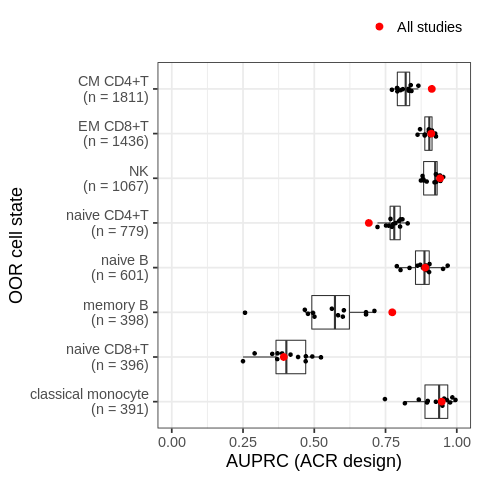

In [642]:
%%R -i auprc_df_min
# pl_df <- auprc_df_all %>%
# distinct(AUPRC, remove_dataset, OOR_state_name_pl) 

auprc_df_min %>%
mutate(OOR_state_name_pl =paste0(OOR_state_name_pl, '\n(n = ', OOR_state_size, ')')) %>%
arrange(OOR_state_size) %>%
mutate(OOR_state_name_pl = factor(OOR_state_name_pl, levels=unique(OOR_state_name_pl))) %>%
ggplot(aes(OOR_state_name_pl, AUPRC)) +
geom_boxplot(data=. %>% filter(remove_dataset != 'none'), outlier.alpha=0) +
geom_jitter(data=. %>% filter(remove_dataset != 'none'), width=0.1) +
geom_point(data=. %>% filter(remove_dataset == 'none'), aes(color='All studies'), size=3) +
scale_color_manual(values=c('All studies'='red'), name='') +
ylim(0,1) +
coord_flip() +
xlab("OOR cell state") + ylab("AUPRC (ACR design)") +
theme_bw(base_size=18) +
theme(legend.position='top', legend.justification=1) +
ggsave(paste0(figdir, 'leaveoneout_oor_state_boxplot.pdf'), width=8, height=7)

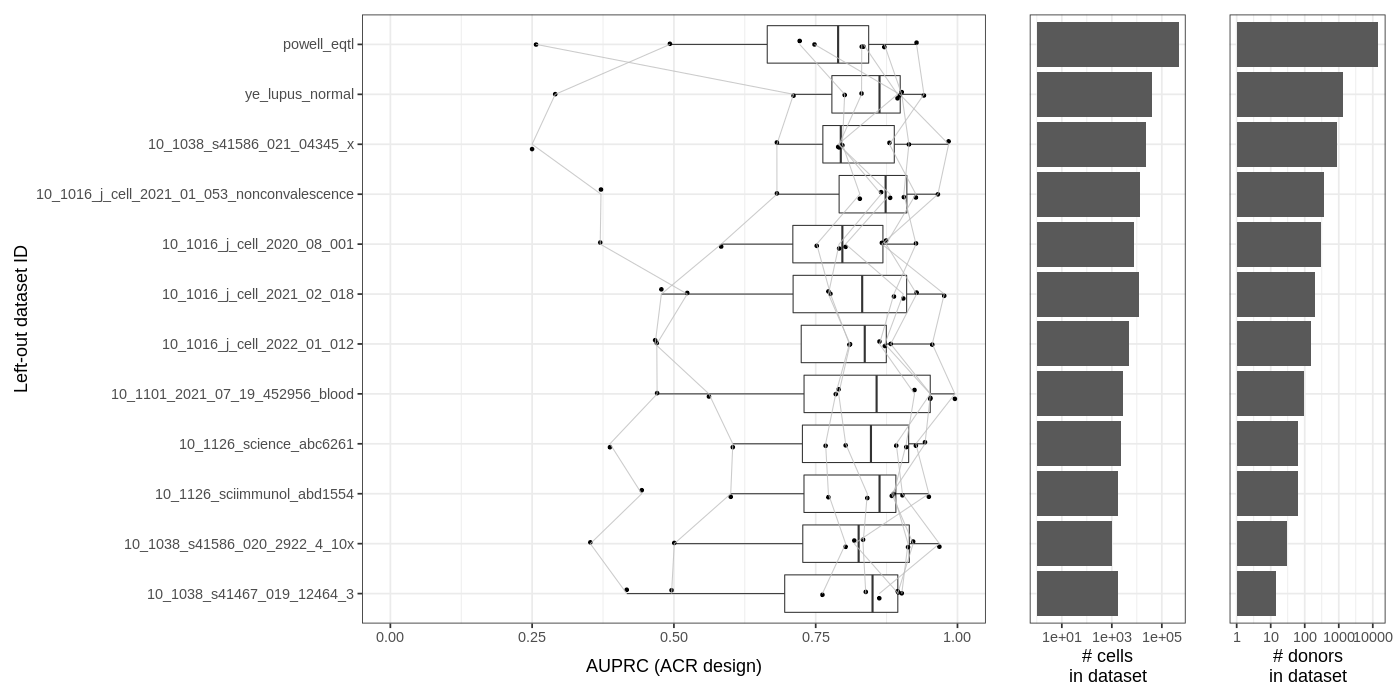

In [653]:
%%R -i auprc_df_min -w 1400 -h 700
library(patchwork)

pl_df <- auprc_df_min %>%
    distinct(AUPRC, remove_dataset, OOR_state_name_pl, remove_dataset_ndonors, remove_dataset_size) %>%
    arrange(remove_dataset_ndonors) %>%
    filter(remove_dataset != 'none') %>%
    mutate(remove_dataset=factor(remove_dataset, levels=unique(remove_dataset))) 

p1 <- pl_df %>%
    ggplot(aes(remove_dataset, AUPRC)) +
    geom_boxplot(outlier.alpha=0) +
    geom_jitter(width=0.1) +
    geom_line(aes(group = OOR_state_name_pl), color='grey', size=0.5, alpha=0.8) +
    ylim(0,1) +
    coord_flip() +
    xlab('Left-out dataset ID') +
    ylab("AUPRC (ACR design)") +
    # facet_wrap(OOR_state_name_pl~.) +
    theme_bw(base_size=18)
    
pl2 <- pl_df %>%
    group_by(remove_dataset) %>%
    summarise(remove_dataset_size = first(remove_dataset_size)) %>%
    ggplot(aes(remove_dataset, remove_dataset_size)) + geom_col() +
    coord_flip() +
    scale_y_log10() +
    theme_bw(base_size=18) +
    xlab('') + ylab('# cells\nin dataset') +
    theme(axis.text.y=element_blank(), axis.ticks.y=element_blank()) 
    
pl3 <- pl_df %>%
    group_by(remove_dataset) %>%
    summarise(remove_dataset_ndonors = first(remove_dataset_ndonors)) %>%
    ggplot(aes(remove_dataset, remove_dataset_ndonors)) + geom_col() +
    coord_flip() +
    scale_y_log10() +
    theme_bw(base_size=18) +
    xlab('') + ylab('# donors\nin dataset') +
    theme(axis.text.y=element_blank(), axis.ticks.y=element_blank()) 
    
(p1 | pl2 | pl3 ) + plot_layout(widths=c(4,1,1)) +
ggsave(paste0(figdir, 'leaveoneout_dataset_size_fig.pdf'), width=16, height=8)

Make some figures for the reviewer

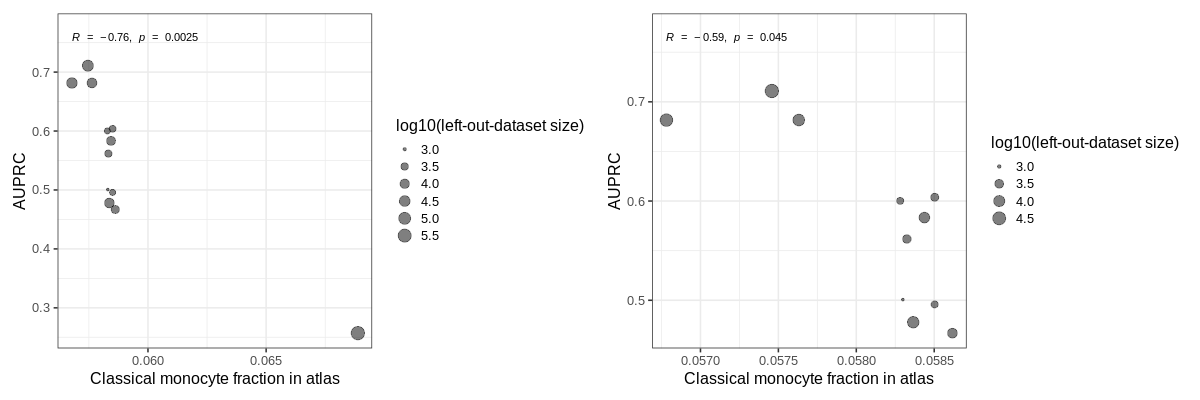

In [643]:
%%R -w 1200 -h 400
p1 <- auprc_df_min %>%
filter(OOR_state_name == 'memory_B_cell') %>%
# filter(remove_dataset!='powell_eqtl') %>%
ggplot(aes(nmonos_atlas_total, AUPRC)) +
geom_point(alpha=0.5, aes(size=log10(remove_dataset_size))) +
# facet_wrap(OOR_state_name_pl~., scales='free', labeller='label_both') +
theme_bw(base_size=16) +
ggpubr::stat_cor() +
scale_size(name='log10(left-out-dataset size)') +
xlab('Classical monocyte fraction in atlas')

p2 <- auprc_df_min %>%
filter(OOR_state_name == 'memory_B_cell') %>%
filter(remove_dataset!='powell_eqtl') %>%
ggplot(aes(nmonos_atlas_total, AUPRC)) +
geom_point(alpha=0.5, aes(size=log10(remove_dataset_size))) +
# facet_wrap(OOR_state_name_pl~., scales='free', labeller='label_both') +
theme_bw(base_size=16) +
scale_size(name='log10(left-out-dataset size)') +
ggpubr::stat_cor() +
xlab('Classical monocyte fraction in atlas')

(p1 | p2) +
ggsave(paste0(figdir, 'reviewer_fig_AUPRC_leaveoneout_CD14lo_monos.png'), width=15, height=5) +
ggsave(paste0(figdir, 'reviewer_fig_AUPRC_leaveoneout_CD14lo_monos.pdf'), width=15, height=5)

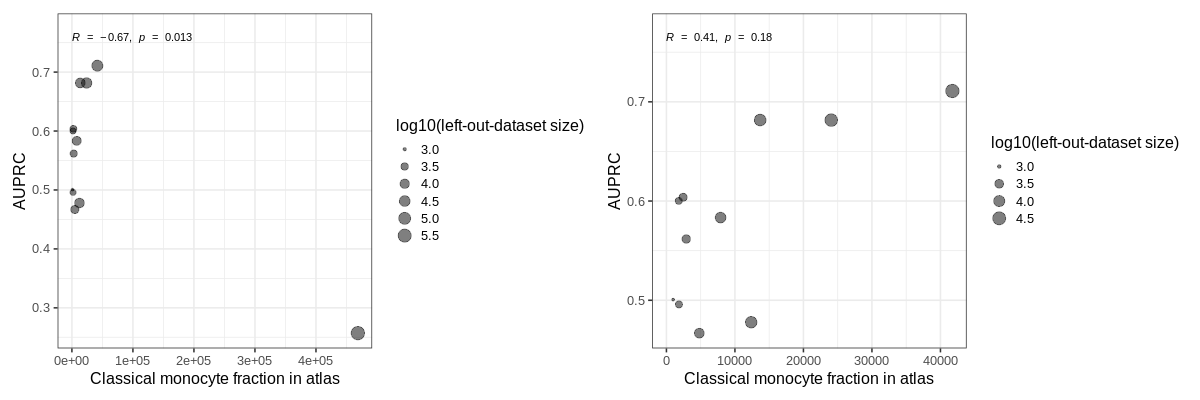

In [651]:
%%R -w 1200 -h 400
p1 <- auprc_df_min %>%
filter(OOR_state_name == 'memory_B_cell') %>%
# filter(remove_dataset!='powell_eqtl') %>%
ggplot(aes(remove_dataset_size, AUPRC)) +
geom_point(alpha=0.5, aes(size=log10(remove_dataset_size))) +
# facet_wrap(OOR_state_name_pl~., scales='free', labeller='label_both') +
theme_bw(base_size=16) +
ggpubr::stat_cor() +
scale_size(name='log10(left-out-dataset size)') +
xlab('Classical monocyte fraction in atlas')

p2 <- auprc_df_min %>%
filter(OOR_state_name == 'memory_B_cell') %>%
filter(remove_dataset!='powell_eqtl') %>%
ggplot(aes(remove_dataset_size, AUPRC)) +
geom_point(alpha=0.5, aes(size=log10(remove_dataset_size))) +
# facet_wrap(OOR_state_name_pl~., scales='free', labeller='label_both') +
theme_bw(base_size=16) +
scale_size(name='log10(left-out-dataset size)') +
ggpubr::stat_cor() +
xlab('Classical monocyte fraction in atlas')

(p1 | p2) 
# +
# ggsave(paste0(figdir, 'reviewer_fig_AUPRC_leaveoneout_CD14lo_monos.png'), width=15, height=5) +
# ggsave(paste0(figdir, 'reviewer_fig_AUPRC_leaveoneout_CD14lo_monos.pdf'), width=15, height=5)

In [645]:
def get_adj_dataset_entropy(ct_size, remove_dataset, OOR_state_name):
    '''
    Compute normalized entropy of cell type distribution in dataset
    '''
    ct_size_dataset = ct_size[(ct_size['dataset_id'] != query_batch) & (ct_size['dataset_id'] != remove_dataset) & (ct_size['cell_type'] != OOR_state_name)]
    n_cells = ct_size_dataset.groupby('cell_type')['n_cells'].sum()
    n_cells = n_cells[n_cells > 0]
    n_s = n_cells.sum()
    p_i_s = n_cells/n_s
    k = len(p_i_s)
    adj_entropy = (- sum(p_i_s * np.log2(p_i_s) ) / np.log2(k) ) - 1
    return(adj_entropy, k)

def get_dataset_frac_variance(ct_size, remove_dataset, OOR_state_name):
    '''
    Compute correlation btw cell type distribution btw atlas and query
    '''
#     n_cells_query = ct_size[ct_size['dataset_id'] == query_batch].set_index('cell_type')['n_cells']
    ct_size_dataset = ct_size[(ct_size['dataset_id'] != query_batch) & (ct_size['dataset_id'] != remove_dataset) & (ct_size['cell_type'] != OOR_state_name)]
    n_cells_atlas = ct_size_dataset.groupby('cell_type').sum()['n_cells']
    var_cts = n_cells_atlas.min()
#     n_cells_df = pd.concat([n_cells_atlas, n_cells_query], 1).fillna(0)
#     n_cells_df.columns = ['n_cells_atlas', 'n_cells_query']
#     n_cells_df = n_cells_df/n_cells_df.sum()
#     n_cells_df['']
#     n_cells_df = n_cells_df.drop(OOR_state_name, axis=0)
#     r2 = n_cells_df.corr().loc['n_cells_atlas', 'n_cells_query']
    return(var_cts)

In [646]:
# auprc_df_min = auprc_df_all.drop_duplicates(['remove_dataset', "OOR_state_name", 'AUPRC']).copy()
auprc_df_min['adj_dataset_entropy'] = [get_adj_dataset_entropy(ct_size, x['remove_dataset'], x['OOR_state_name'])[0] for i,x in auprc_df_min.iterrows()]
auprc_df_min['n_cell_types'] = [get_adj_dataset_entropy(ct_size, x['remove_dataset'], x['OOR_state_name'])[1] for i,x in auprc_df_min.iterrows()]
auprc_df_min['frac_variance'] = [get_dataset_frac_variance(ct_size, x['remove_dataset'], x['OOR_state_name']) for i,x in auprc_df_min.iterrows()]

In [647]:
auprc_df_min['OOR_state_size'] = [ct_size[ct_size['dataset_id'] == query_batch].set_index("cell_type")['n_cells'].loc[x] for x in auprc_df_min['OOR_state_name']]
# auprc_df_min['OOR_state_size'] = [ct_size[(ct_size['dataset_id'] != query_batch) & (ct_size['dataset_id'] != x['remove_dataset'])].groupby("cell_type").sum()['n_cells'].loc[x['OOR_state_name']] for _,x in auprc_df_min.iterrows()]

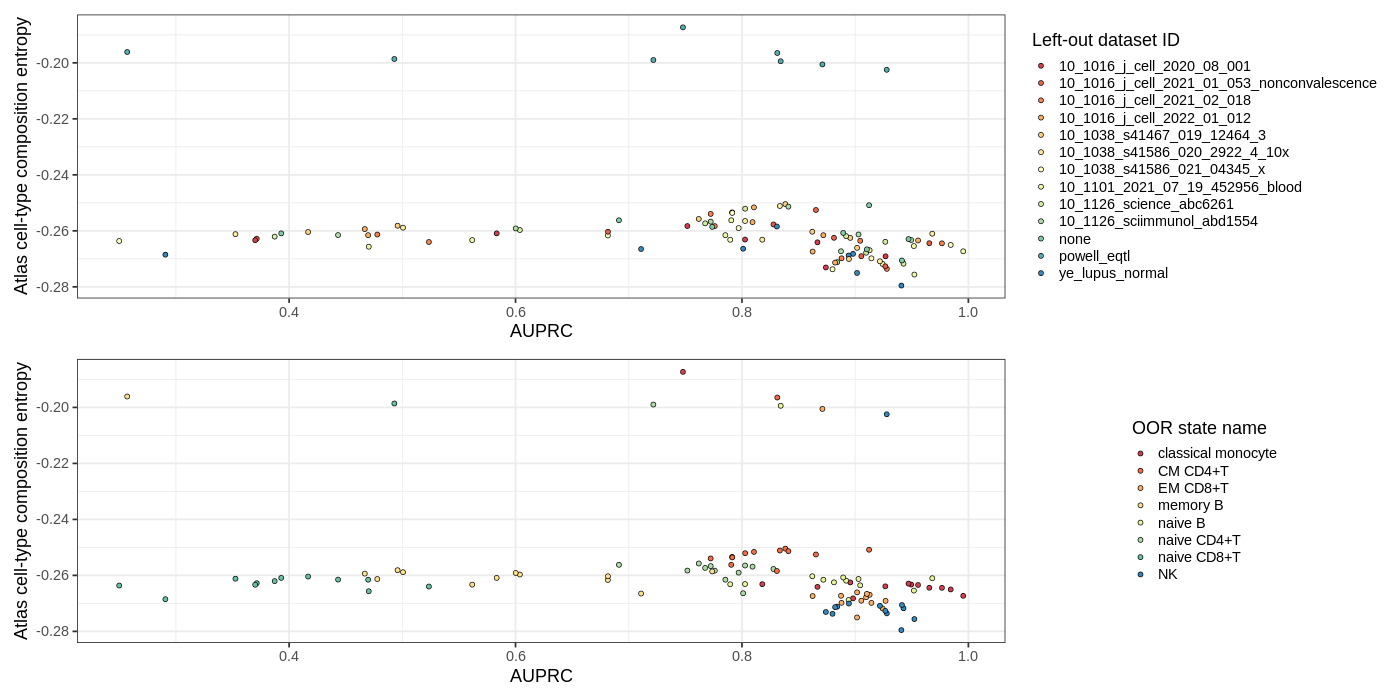

In [648]:
%%R -i auprc_df_min -w 1400 -h 700
library(RColorBrewer)
getPalette = colorRampPalette(brewer.pal(9, "Spectral"))

p1 <- auprc_df_min %>%
    ggplot(aes(AUPRC, adj_dataset_entropy, fill=remove_dataset))+
    # geom_line(aes(group=remove_dataset))+
    geom_point(shape=21, size=2) +
    theme_bw(base_size=18) +
    ylab('Atlas cell-type composition entropy') +
    scale_fill_manual(values = getPalette(13), name='Left-out dataset ID')

p2 <- auprc_df_min %>%
    ggplot(aes(AUPRC, adj_dataset_entropy, fill=OOR_state_name_pl))+
    # geom_line(aes(group=remove_dataset))+
    geom_point(shape=21, size=2) +
    theme_bw(base_size=18) +
    ylab('Atlas cell-type composition entropy') +
    scale_fill_brewer(palette='Spectral', name='OOR state name')
    
(p1 / p2) +
ggsave(paste0(figdir, 'rebuttal_figure_entropy.pdf'), width=12, height=15)
